In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from time import time
from operator import itemgetter

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}/'.format(SELECT_YEAR)


In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(10)

CPU times: user 95.1 ms, sys: 3.63 ms, total: 98.8 ms
Wall time: 111 ms
(2984, 4) docs shape


,id,doc,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",26
1,105670521813027,Gene expression analysis in <i>Musa acuminata<...,"[gene, express, analysi, musa, acuminata, comp...",19
2,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14
3,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",61
4,117460865270656,YBS heuristic for routing and spectrum allocat...,"[ybs, heurist, rout, spectrum, alloc, flexibl,...",33
5,120615995402345,Efficient and Modular Consensus-Free Reconfigu...,"[effici, modular, consensus, free, reconfigur,...",8
6,122307432250869,Quaternion-based Deep Belief Networks Fine-Tun...,"[quaternion, base, deep, belief, network, fine...",37
7,122321907341579,A Brazilian look at occupational health and sa...,"[brazilian, look, occup, health, safeti, usa, ...",17
8,122916218414168,IoT Applied To Precision LABCONM: A Remote Lab...,"[iot, appli, precis, labconm, remot, lab, lear...",33
9,125036186628507,Self-Adaptive Role-Based Access Control for Bu...,"[self, adapt, role, base, access, control, bus...",7


Time: 3.85 mins


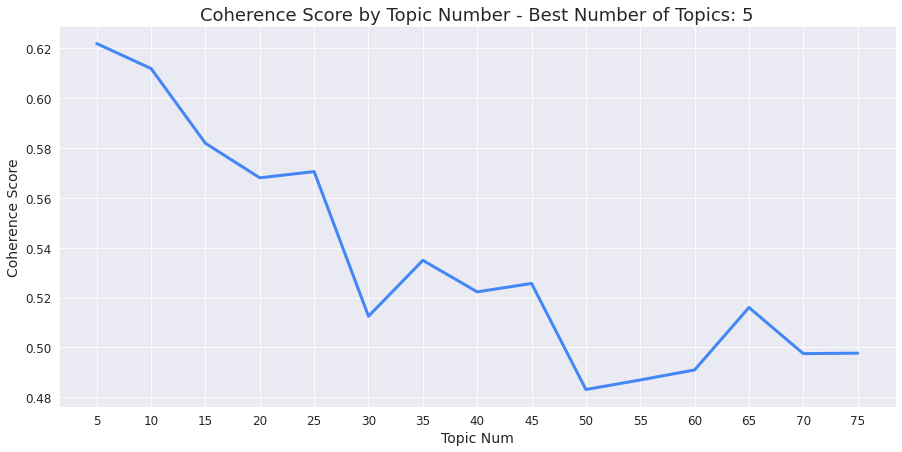

In [3]:
# Use Gensim's NMF to get the best num of topics via coherence score
t = time()
texts = df['clean']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

file_name = '{}_c_score'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

print('Time: {} mins'.format(round((time() - t) / 60, 2)))
plt.show()

In [4]:
# Create the tfidf
texts = df['clean']

tfidf_vectorizer = TfidfVectorizer(
    min_df=0.005,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_fn = tfidf_vectorizer.get_feature_names()

print('vocabulary: {}'.format(len(tfidf_vectorizer.vocabulary_)))
print('sparse matrix shape: {}'.format(tfidf.shape))
print('nonzero count: {}'.format(tfidf.nnz))
print('sparsity: {:.3f}'.format(100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



vocabulary: 926
sparse matrix shape: (2984, 926)
nonzero count: 45940
sparsity: 1.663


,term,weight
75,base,0.035703
888,use,0.034956
528,model,0.030993
823,system,0.029263
555,network,0.028066
39,analysi,0.025988
207,data,0.023313
50,approach,0.021037
31,algorithm,0.019205
807,studi,0.019055


In [5]:
# Run the nmf model
nmf = NMF(
    n_components=10,
    #n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

idx_to_word = np.array(tfidf_fn)
for i, topic in enumerate(nmf.components_):
    print('Topic {}: {}'.format(i + 1, ','.join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: applic,multi,perform,architectur,comput,time,cloud,base,control,system
Topic 2: method,featur,recognit,base,neural network,neural,classif,detect,use,imag
Topic 3: multi object,schedul,object,heurist,multi,genet algorithm,genet,optim,algorithm,problem
Topic 4: neural network,neural,rout,mobil,manag,wireless sensor,sensor network,sensor,wireless,network
Topic 5: adapt,machin learn,object,machin,teach,learn environ,virtual,educ,environ,learn
Topic 6: approach,stream,big data,big,visual,manag,open,data mine,mine,data
Topic 7: measur,differ,gene,brazilian,use,effect,genom,structur,brazil,analysi
Topic 8: estim,busi,ontolog,base model,model base,use,process,base,simul,model
Topic 9: project,engin,test,systemat,case studi,product,case,develop,studi,softwar
Topic 10: free,threshold,larg,number,attribut,complex,color,path,edg,graph


In [6]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["T%d_words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["T%d_wgt" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

display_topics(nmf,tfidf_fn,10)


,T0_words,T0_wgt,T1_words,T1_wgt,T2_words,T2_wgt,T3_words,T3_wgt,T4_words,T4_wgt,T5_words,T5_wgt,T6_words,T6_wgt,T7_words,T7_wgt,T8_words,T8_wgt,T9_words,T9_wgt
0,system,2.117,imag,1.104,problem,1.414,network,1.506,learn,1.849,data,1.617,analysi,1.539,model,1.683,softwar,1.090,graph,1.664
1,control,0.848,use,0.847,algorithm,1.146,wireless,0.605,environ,0.509,mine,0.386,brazil,0.389,simul,0.445,studi,0.745,edg,0.245
2,base,0.725,detect,0.802,optim,0.515,sensor,0.594,educ,0.493,data mine,0.309,structur,0.342,base,0.351,develop,0.561,path,0.213
3,cloud,0.629,classif,0.690,genet,0.463,sensor network,0.498,virtual,0.413,open,0.301,genom,0.323,process,0.254,case,0.532,color,0.198
4,time,0.627,neural,0.570,genet algorithm,0.414,wireless sensor,0.490,learn environ,0.376,manag,0.296,effect,0.317,use,0.224,product,0.423,complex,0.156
5,comput,0.457,neural network,0.531,multi,0.411,manag,0.212,teach,0.304,visual,0.276,use,0.317,model base,0.209,case studi,0.404,attribut,0.136
6,architectur,0.439,base,0.472,heurist,0.352,mobil,0.176,machin,0.294,big,0.231,brazilian,0.308,base model,0.167,systemat,0.380,number,0.135
7,perform,0.403,recognit,0.442,object,0.305,rout,0.161,object,0.278,big data,0.203,gene,0.289,ontolog,0.165,test,0.379,larg,0.131
8,multi,0.395,featur,0.438,schedul,0.259,neural,0.159,machin learn,0.262,stream,0.202,differ,0.206,busi,0.145,engin,0.348,threshold,0.127
9,applic,0.393,method,0.371,multi object,0.259,neural network,0.155,adapt,0.246,approach,0.190,measur,0.191,estim,0.125,project,0.285,free,0.119


In [7]:
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8
topic_df = topic_table(nmf, tfidf_fn, n_top_words).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(word_tokenize) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()


,0,1,2,3,4,5,6,7,topics
0,system,control,base,cloud,time,comput,architectur,perform,system control base cloud time comput architec...
1,imag,use,detect,classif,neural,neural network,base,recognit,imag use detect classif neural network base re...
2,problem,algorithm,optim,genet,genet algorithm,multi,heurist,object,problem algorithm optim genet multi heurist ob...
3,network,wireless,sensor,sensor network,wireless sensor,manag,mobil,rout,network wireless sensor manag mobil rout
4,learn,environ,educ,virtual,learn environ,teach,machin,object,learn environ educ virtual teach machin object


In [8]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,system control base cloud time comput architec...
1,1,imag use detect classif neural network base re...
2,2,problem algorithm optim genet multi heurist ob...
3,3,network wireless sensor manag mobil rout
4,4,learn environ educ virtual teach machin object


In [9]:
id = df['id'].tolist()

df_temp = pd.DataFrame({
    'id': id,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='id',
    how='left'
)

df_topics.head(10)


,id,doc,clean,w_count,topic_num,topics
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",26,5,data mine open manag visual big
1,105670521813027,Gene expression analysis in <i>Musa acuminata<...,"[gene, express, analysi, musa, acuminata, comp...",19,6,analysi brazil structur genom effect use brazi...
2,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14,8,softwar studi develop case product systemat test
3,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",61,7,model simul base process use ontolog
4,117460865270656,YBS heuristic for routing and spectrum allocat...,"[ybs, heurist, rout, spectrum, alloc, flexibl,...",33,3,network wireless sensor manag mobil rout
5,120615995402345,Efficient and Modular Consensus-Free Reconfigu...,"[effici, modular, consensus, free, reconfigur,...",8,0,system control base cloud time comput architec...
6,122307432250869,Quaternion-based Deep Belief Networks Fine-Tun...,"[quaternion, base, deep, belief, network, fine...",37,1,imag use detect classif neural network base re...
7,122321907341579,A Brazilian look at occupational health and sa...,"[brazilian, look, occup, health, safeti, usa, ...",17,4,learn environ educ virtual teach machin object
8,122916218414168,IoT Applied To Precision LABCONM: A Remote Lab...,"[iot, appli, precis, labconm, remot, lab, lear...",33,4,learn environ educ virtual teach machin object
9,125036186628507,Self-Adaptive Role-Based Access Control for Bu...,"[self, adapt, role, base, access, control, bus...",7,7,model simul base process use ontolog


In [10]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 2984 x 926
W = 10 x 926
H = 2984 x 10


In [11]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 2906.28'

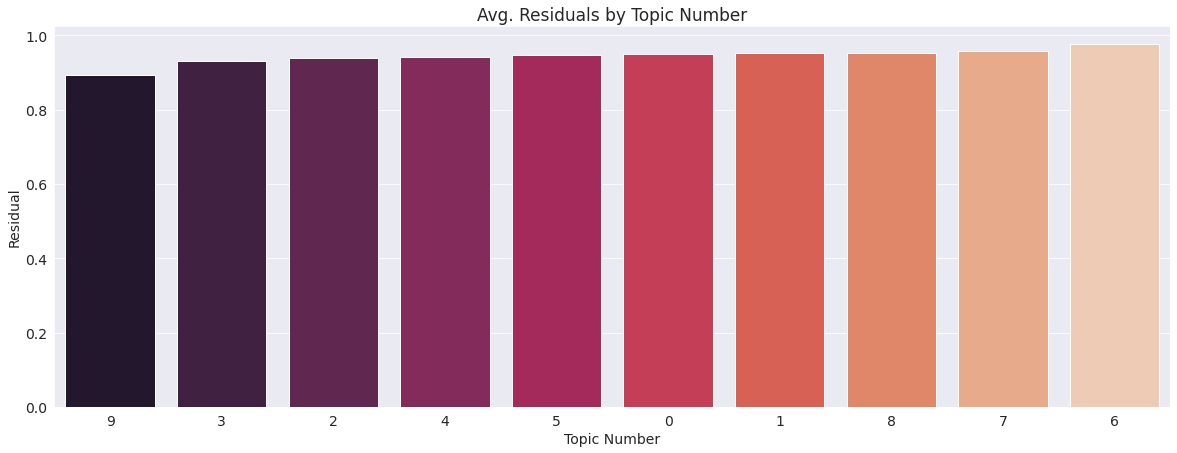

In [12]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = '{}_avg_resid'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

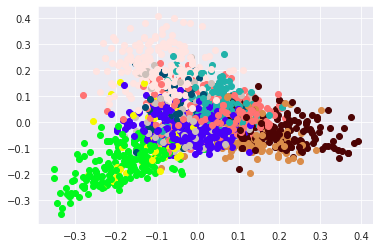

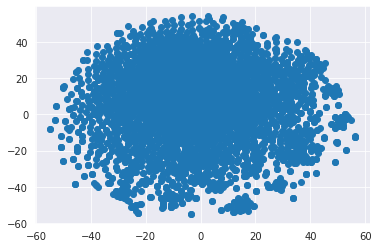

In [13]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tfidf)
#print(labels)

X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
#print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    #print(instance, index, labels[index])
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()